In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from tensorflow.keras.utils import to_categorical

import numpy as np
import os
from detector import *
import time
import random

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [2]:
if tf.__version__[0] != '2':
    raise ImportError('This notebook requires Tensorflow v2.')
    
#verify gpu is avaiable
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

1 Physical GPUs, 1 Logical GPU


## configurations

In [32]:
# attack = 'CarliniLInfMethodinf'
attack = 'ProjectedGradientDescentinf'

activation = 'sigmoid'
# activation = 'tanh'

# load_benign = True
load_benign = False

load_adv = True
# load_adv = False

# train_autoencoders = True
train_autoencoders = False

# train_anns = True
train_anns = False

# compute_probs = True
compute_probs = False

pred_train_or_test = 'test'
# pred_train_or_test = 'train'

# predict_benign = True
predict_benign = False

predict_adv = True
# predict_adv = False

evaluation = True
# evaluation = False

EXT = '.npy'

folder = './'+attack+'/'+activation+'/'
LAYER = 21
PARTS = 17
# TRAIN_SAMPLES = int(8313 * 0.9)
# TEST_SAMPLES = 8313 - TRAIN_SAMPLES
# ALL_SAMPLES = 8313

data_dir_name = '../../ae_dataset loader/src/logits/vgg19/'+attack

In [4]:
def createAutoEncoderAndTrain(x_train):
    input_shape = x_train[0].flatten().shape[0]
    input_img = Input(shape=(input_shape,))
    encoded = BatchNormalization()(input_img)
    encoded = Dense(160, activation=activation)(encoded)
    encoded = Dense(100, activation=activation)(encoded)

    decoded = Dense(160, activation=activation)(encoded)
    decoded = Dense(input_shape, activation=activation)(decoded)
    
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    autoencoder.fit(x_train, x_train,
                epochs=45,
                batch_size=512,
                shuffle=True,
                validation_split = 0.1,                   
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=3)]
                   )
    return autoencoder

In [5]:
def load_logits(benign_or_adv):
    logits = []
    for i in range(LAYER):
            layer_logits = []
            count = 0
            # print('[{:11.2f}s][+] train activation space: layer {}/21'.format(time.time() - start, i + 1))
            for j in range(PARTS):
                f_x_train = np.load(os.path.join(data_dir_name, benign_or_adv, 'layer_{}_{}'.format(i, j) + EXT))
                flatten_shape = 1
    #             print(f_x_train.shape)
                for shape_index in range(1, len(f_x_train.shape)):
                    flatten_shape = flatten_shape * f_x_train.shape[shape_index]
                f_x_train = f_x_train.flatten().reshape(f_x_train.shape[0], flatten_shape)
    #             print(f_x_train.shape)
                layer_logits.append(f_x_train)
            layer_logits = np.array(layer_logits)
            layer_logits = np.concatenate(layer_logits, axis=0)
            logits.append(layer_logits)
    return logits

In [6]:
if load_benign:
    benign_logits = load_logits('benign')
    logits = benign_logits

In [7]:
if load_adv:
    adv_logits = load_logits('adversarial')
    logits = adv_logits

In [33]:
if load_benign or load_adv:
    n_layers = len(logits)
    n_samples = logits[0].shape[0]

In [34]:
#extract train test
n_train_samples = int(n_samples * 0.9)
n_test_samples = n_samples - n_train_samples

# random.seed(os.urandom(5))
seed = 1337
all_indexes = np.arange(0, n_samples, 1)
random.Random(seed).shuffle(all_indexes)
train_indexes = all_indexes[:n_train_samples]
test_indexes = all_indexes[n_train_samples:]
print(all_indexes)
print(train_indexes.shape)
print(test_indexes.shape)

[4952 1595 2952 ... 5452 2714 5994]
(7833,)
(871,)


In [35]:
#train autoencoders
if train_autoencoders:
    for layer_index in range(n_layers):
        print('layer: ', layer_index)
        layer_encoder= createAutoEncoderAndTrain((benign_logits[layer_index])[train_indexes])
        layer_encoder.save(folder+'autoencoders/layer_'+str(layer_index)+'.hdf5')   

In [36]:
y = np.load(os.path.join(data_dir_name, 'labels_benign.npy'))
y_hot = to_categorical(y)
y_train = y_hot[train_indexes]
y_test = y_hot[test_indexes]
print(y_train.shape)
print(y_test.shape)

(7833, 10)
(871, 10)


In [37]:
def createAndTrainAnn(x_train, y_train):
    model = Sequential()
    model.add(Dense(100, input_dim=x_train[0].shape[0], activation='relu'))
    model.add(Dense(10, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(x_train,
              y_train,
              epochs=70,
              batch_size=512,
              shuffle=True,
              validation_split = 0.1,
              callbacks = [tf.keras.callbacks.EarlyStopping(patience=3)]
             )
    return model

In [38]:
def encode_from_autoencoder(autoencoder, data):
    model = autoencoder
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[3].output)
    intermediate_output = intermediate_layer_model.predict(data, batch_size=512)
    return intermediate_output

In [39]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [40]:
#train and save ann
if train_anns:
    layers_ann = []
    train_layers_predictions = []
    for layer_index in range(n_layers):
        x_train = (benign_logits[layer_index])[train_indexes]
        filepath = folder+'autoencoders/layer_'+str(layer_index)+'.hdf5'
        layer_autoencoder = tf.keras.models.load_model(filepath)
        encoded = encode_from_autoencoder(layer_autoencoder, x_train)
        print('layer number: ', layer_index)
        layer_ann = createAndTrainAnn(encoded, y_train)
        layer_ann.save(folder+'anns/layer_'+str(layer_index)+'.hdf5') 
        layers_ann.append(layer_ann)
    #     train_layers_predictions.append(tf.argmax(layer_ann.predict(encoded, batch_size=512), axis=0))
else:
    #load anns
    layers_ann = []
    train_layers_predictions = []
    for layer_index in range(n_layers):
        layer_ann = tf.keras.models.load_model(folder+'anns/layer_'+str(layer_index)+'.hdf5')
        layers_ann.append(layer_ann)

In [41]:
def get_layers_predictions(layers_ann, logits, layer_indexes):
    layers_predictions = []
    for layer_index in range(n_layers):
        x_train = (logits[layer_index])[layer_indexes]
        filepath = folder+'autoencoders/layer_'+str(layer_index)+'.hdf5'
        layer_autoencoder = tf.keras.models.load_model(filepath)
        encoded = encode_from_autoencoder(layer_autoencoder, x_train)
#         print(encoded.shape)
        layers_predictions.append(tf.argmax(layers_ann[layer_index].predict(encoded, batch_size=512), axis=1))
    return layers_predictions

## compute probs

In [42]:
if compute_probs:
    train_layers_predictions = get_layers_predictions(layers_ann, benign_logits, train_indexes)

    layer_prob = []
    for layer_index in range(1, n_layers):
        cur_layer_pred = train_layers_predictions[layer_index]
        prev_layer_pred =train_layers_predictions[layer_index-1]
        count_diff = tf.reduce_sum(tf.cast(cur_layer_pred != prev_layer_pred, tf.float32))
        layer_prob.append(count_diff / train_layers_predictions[layer_index].shape[0])
        print(count_diff)
    tf.print(layer_prob)
    np.save(folder+'layer_prob.npy', layer_prob)
else:
    layer_prob = np.load(folder+'layer_prob.npy')
    layer_prob+= float(1e-32)

In [43]:
#[0.36128488931665065, 0.36453320500481234, 0.23472088546679498, 0.21246390760346487, 0.1347449470644851, 0.10190086621751684, 0.021896053897978825, 0.001203079884504331, 1e-38, 1e-38, 1e-38, 1e-38, 1e-38, 1e-38, 1e-38, 1e-38, 1e-38, 1e-38, 1e-38, 1e-38]

In [44]:
# layer_prob += [float(1e-32)
for prob in layer_prob:
    tf.print(prob)

0.44274226
0.4589557
0.5818971
0.6336014
0.45793438
0.743138
0.56044936
0.1940508
0.054002296
0.055917274
0.036767524
0.010340866
0.000127665
1e-32
0.000127665
0.000127665
1e-32
1e-32
1e-32
0.00076599006


In [45]:
def get_loglikelihood(predictions, layer_prob):
    log_likeligood = np.zeros(predictions[0].shape[0])
    for layer_index in range(1, len(predictions)):
        cur_layer_pred = predictions[layer_index]
        prev_layer_pred = predictions[layer_index-1]
        pred_changed = tf.cast(cur_layer_pred != prev_layer_pred, tf.float32)
        changed_indexes = pred_changed == 1
        same_indexes = pred_changed == 0
        log_likeligood[changed_indexes]+= np.full((np.sum(changed_indexes)), tf.math.log(layer_prob[layer_index-1]))        
        
        log_likeligood[same_indexes]+= np.full((np.sum(same_indexes)), tf.math.log(1-layer_prob[layer_index-1]))
    print(log_likeligood)
    return log_likeligood

In [46]:
if(pred_train_or_test == 'train'):
    indexes = train_indexes
else:
    indexes = test_indexes

In [47]:
train_or_test = pred_train_or_test

In [48]:
folder+train_or_test

'./ProjectedGradientDescentinf/sigmoid/test'

In [49]:
if predict_benign:
    benign_pred = get_layers_predictions(layers_ann, benign_logits, indexes)
    benign_log = get_loglikelihood(benign_pred, layer_prob)
    np.save(folder+train_or_test+'_benign_log.npy', benign_log)
else:
    benign_log = np.load(folder+train_or_test+'_benign_log.npy')

In [50]:
if predict_adv:
    adv_pred = get_layers_predictions(layers_ann, adv_logits, indexes)
    adv_log = get_loglikelihood(adv_pred, layer_prob)
    np.save(folder+train_or_test+'_adv_log.npy', adv_log)
else:
    adv_log = np.load(folder+train_or_test+'_adv_log.npy')

[  -6.47910809   -4.79209944   -6.09742825   -6.42901884   -5.51729112
   -5.33568404   -5.78894966  -93.31838386   -7.04830298   -6.04998167
   -4.94109654   -6.03193562   -5.10564397   -6.23612213   -7.50842135
   -5.08355662   -4.94109654   -5.74733119   -6.57963397   -5.02217774
  -17.61839634   -5.74733119   -4.22737966   -5.41676524   -6.06746094
   -6.41508654   -4.06283223   -4.47447938   -8.03435029   -4.63902682
  -13.35127502   -6.52954472   -5.1711366    -6.75958479   -4.80504534
   -4.94109654   -4.94109654   -6.45898615   -6.1284202   -17.22380884
   -4.80093158   -5.33568404   -5.70136967   -4.80504534  -95.53717541
   -5.33568404  -10.86069086   -6.64512661   -7.45583637   -4.06283223
  -10.12864907   -5.0350854   -10.58631334   -6.56668808   -5.51729112
   -5.1711366    -6.96072299   -5.92876706   -6.1284202    -4.61053059
   -4.94109654   -5.50434522   -4.62608092   -5.45838371   -4.95664687
   -5.50434522   -8.91319537   -6.41508654   -8.06902736   -6.96072299
  -10.

In [51]:
benign_log.shape

(871,)

In [52]:
adv_log.shape

(871,)

In [53]:
train_or_test

'test'

In [54]:
# if evaluation:
#     logs = np.concatenate((benign_log, adv_log))
#     y_logs = [0] * len(benign_log) + [1] * len(adv_log)
#     print(len(logs))
#     print(len(y_logs))

#     fpr, tpr, thresholds = roc_curve(y_logs, logs, pos_label=0)
#     roc_auc = auc(fpr, tpr)

#     lw = 2
#     plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#     plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
#     plt.xlim([-0.02, 1.02])
#     plt.ylim([-0.02, 1.02])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic graph')
#     plt.legend(loc="lower right")

#     plt.savefig(folder+train_or_test+'_roc_auc.png')
#     plt.show(block=True)
#     plt.clf()

#     lr_precision, lr_recall, _ = precision_recall_curve(y_logs, logs, pos_label=0)
#     precision_recall_auc = auc(lr_recall, lr_precision)

#     lw = 2
#     plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
#     plt.plot(lr_recall, lr_precision, color='darkorange', lw=lw, label='precision recall curve (area = %0.3f)' % precision_recall_auc)
#     plt.xlim([-0.02, 1.02])
#     plt.ylim([-0.02, 1.02])
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.title('Precision Recall graph')
#     plt.legend(loc="lower right")

#     plt.savefig(folder+train_or_test+'_precision_recall_auc.png')
#     plt.show(block=True)
#     plt.clf()

#     plt.figure(figsize=(50,50))
#     plt.bar(np.arange(benign_log.shape[0]), benign_log, color='#7f6d5f', label='benign', align='edge')
#     plt.bar(np.arange(adv_log.shape[0])+ benign_log.shape[0], adv_log, color='000000', label='adv', align='edge')
#     plt.legend()
#     plt.savefig(folder+attack+'_'+train_or_test+'_histogram.png')
#     plt.show()

In [55]:
len(adv_log)

871

1742
1742


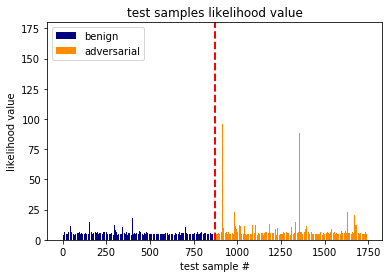

<Figure size 432x288 with 0 Axes>

In [56]:
if evaluation:
    logs = np.concatenate((benign_log, adv_log))
    y_logs = [0] * len(benign_log) + [1] * len(adv_log)
    print(len(logs))
    print(len(y_logs))

#     fpr, tpr, thresholds = roc_curve(y_logs, logs, pos_label=0)
#     roc_auc = auc(fpr, tpr)

    lw = 2
#     plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#     plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
#     plt.xlim([-0.02, 1.02])
#     plt.ylim([-0.02, 1.02])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic graph')
#     plt.legend(loc="lower right")

#     plt.savefig(folder+train_or_test+'_roc_auc.png')
#     plt.show(block=True)
#     plt.clf()

#     lr_precision, lr_recall, _ = precision_recall_curve(y_logs, logs, pos_label=0)
#     precision_recall_auc = auc(lr_recall, lr_precision)

#     lw = 2
#     plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
#     plt.plot(lr_recall, lr_precision, color='darkorange', lw=lw, label='precision recall curve (area = %0.3f)' % precision_recall_auc)
#     plt.xlim([-0.02, 1.02])
#     plt.ylim([-0.02, 1.02])
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.title('Precision Recall graph')
#     plt.legend(loc="lower right")

#     plt.savefig(folder+train_or_test+'_precision_recall_auc.png')
#     plt.show(block=True)
#     plt.clf()
    
    
# ----------------------------------    

#     plt.figure(figsize=(50,50))
#     plt.bar(np.arange(benign_log.shape[0]), benign_log, color='#7f6d5f', label='benign', align='edge')
#     plt.bar(np.arange(adv_log.shape[0])+ benign_log.shape[0], adv_log, color='000000', label='adv', align='edge')
#     plt.legend()
#     plt.savefig(folder+attack+'_'+train_or_test+'_histogram.png')
#     plt.show()

#     plt.figure(figsize=(15, 15))
    plt.xlabel('test sample #')
    plt.ylabel('likelihood value')
    plt.title('test samples likelihood value')    
    plt.ylim([-0.02, 180.00])
    plt.axvline(x=len(benign_log), linewidth=lw, color='r', linestyle='--')
    plt.bar(np.arange(benign_log.shape[0]), benign_log*-1, color='navy', label='benign', align='edge')
    plt.bar(np.arange(adv_log.shape[0])+ benign_log.shape[0], adv_log*-1, color='darkorange', label='adversarial',
            align='edge')
    plt.legend()
    plt.savefig(folder+attack+'_'+train_or_test+'_histogram.png')
    # plt.show(block=True)
    plt.show()
    plt.clf()